In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import sqlalchemy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


In [2]:
# load
PATH = r"C:/Users/gomathi/desktop/project/clean_ecommerce_return_dataset (1).csv"
df = pd.read_csv(PATH, low_memory=False)

In [3]:
#Data check
print(df.shape)
print(df.columns)


(600, 16)
Index(['order_id', 'order_date', 'customer_id', 'product_id', 'category',
       'subcategory', 'supplier', 'city', 'locality', 'marketing_channel',
       'price', 'discount_percent', 'order_quantity', 'delivery_days',
       'return_status', 'return_reason'],
      dtype='object')


In [4]:
df['order_date'] = pd.to_datetime(df['order_date'], format="%d-%m-%Y %H:%M", errors='coerce', dayfirst=True)

df.head()

,order_id,order_date,customer_id,product_id,category,subcategory,supplier,city,locality,marketing_channel,price,discount_percent,order_quantity,delivery_days,return_status,return_reason
0,1,2024-11-18,1988,6122,Fashion,Kids,Supplier_A,Bangalore,Koramangala,Instagram,15577,19,3,7,0,No reason provided
1,2,2024-04-23,1638,5047,Beauty,Makeup,Supplier_A,Bangalore,Indiranagar,Facebook,5864,46,1,4,0,No reason provided
2,3,2024-04-06,1208,6092,Home,Decor,Supplier_C,Delhi,Saket,Affiliate,8185,3,3,5,0,No reason provided
3,4,2024-03-25,1559,5504,Home,Decor,Supplier_D,Hyderabad,Madhapur,Instagram,17743,41,1,5,0,No reason provided
4,5,2024-08-01,1630,5862,Electronics,Accessories,Supplier_B,Chennai,T. Nagar,Google Ads,2538,33,1,9,0,No reason provided


In [5]:
df.isnull().sum()

order_id             0
order_date           0
customer_id          0
product_id           0
category             0
subcategory          0
supplier             0
city                 0
locality             0
marketing_channel    0
price                0
discount_percent     0
order_quantity       0
delivery_days        0
return_status        0
return_reason        0
dtype: int64

In [6]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].describe()


count      600.000000
mean     10119.018333
std       5586.619878
min        222.000000
25%       5371.500000
50%       9921.500000
75%      14891.250000
max      19949.000000
Name: price, dtype: float64

In [7]:
df['order_date'] = pd.to_datetime(df['order_date'], format="%d-%m-%Y %H:%M", errors='coerce')



In [8]:
df.rename(columns={'return_status': 'return_flag'}, inplace=True)


In [9]:
df = df.dropna(subset=['return_flag'])


## Total return percentage

In [10]:
return_rate = df['return_flag'].mean() * 100
print(f"Total Return Rate: {return_rate:.2f}%")


Total Return Rate: 18.00%


## Return % by Category

In [11]:
category_returns = df.groupby('category')['return_flag'].mean() * 100
print(category_returns)


category
Beauty         23.140496
Electronics    15.000000
Fashion        17.355372
Home           20.512821
Sports         13.861386
Name: return_flag, dtype: float64


## Return % by Supplier

In [12]:
supplier_returns = df.groupby('supplier')['return_flag'].mean() * 100
print(supplier_returns)


supplier
Supplier_A    19.871795
Supplier_B    23.776224
Supplier_C    15.540541
Supplier_D    13.071895
Name: return_flag, dtype: float64


## Import and Prepare Data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Target variable
y = df['return_flag']

# Features (remove return flag + date column)
X = df.drop(columns=['return_flag', 'order_date'])


## Detect which columns are text

In [14]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)


Categorical: Index(['category', 'subcategory', 'supplier', 'city', 'locality',
       'marketing_channel', 'return_reason'],
      dtype='object')
Numeric: Index(['order_id', 'customer_id', 'product_id', 'price', 'discount_percent',
       'order_quantity', 'delivery_days'],
      dtype='object')


## Build Model with Encoder + Logistic Regression

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [16]:
df = pd.read_csv("clean_ecommerce_return_dataset (1).csv")
df.head()


,order_id,order_date,customer_id,product_id,category,subcategory,supplier,city,locality,marketing_channel,price,discount_percent,order_quantity,delivery_days,return_status,return_reason
0,1,18-11-2024 00:00,1988,6122,Fashion,Kids,Supplier_A,Bangalore,Koramangala,Instagram,15577,19,3,7,0,No reason provided
1,2,23-04-2024 00:00,1638,5047,Beauty,Makeup,Supplier_A,Bangalore,Indiranagar,Facebook,5864,46,1,4,0,No reason provided
2,3,06-04-2024 00:00,1208,6092,Home,Decor,Supplier_C,Delhi,Saket,Affiliate,8185,3,3,5,0,No reason provided
3,4,25-03-2024 00:00,1559,5504,Home,Decor,Supplier_D,Hyderabad,Madhapur,Instagram,17743,41,1,5,0,No reason provided
4,5,01-08-2024 00:00,1630,5862,Electronics,Accessories,Supplier_B,Chennai,T. Nagar,Google Ads,2538,33,1,9,0,No reason provided


In [17]:
print(df.columns)


Index(['order_id', 'order_date', 'customer_id', 'product_id', 'category',
       'subcategory', 'supplier', 'city', 'locality', 'marketing_channel',
       'price', 'discount_percent', 'order_quantity', 'delivery_days',
       'return_status', 'return_reason'],
      dtype='object')


In [18]:
# Select useful numeric features
X = df[["price", "discount_percent", "order_quantity", "delivery_days"]]

# Target (already available)
y = df["return_status"]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [22]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))



Accuracy: 0.8

Confusion Matrix:
 [[96  0]
 [24  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        96
           1       0.00      0.00      0.00        24

    accuracy                           0.80       120
   macro avg       0.40      0.50      0.44       120
weighted avg       0.64      0.80      0.71       120



In [23]:
# -------- IMPORTS --------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------- LOAD DATA --------
df = pd.read_csv("clean_ecommerce_return_dataset (1).csv")  # Use your filename here

# -------- SELECT FEATURES + TARGET --------
X = df[["price", "discount_percent", "order_quantity", "delivery_days"]]
y = df["return_status"]

# -------- SCALE DATA --------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = df.drop('return_status', axis=1)
y = df['return_status']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# -------- TRAIN-TEST SPLIT --------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -------- TRAIN MODEL --------
model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

# -------- PREDICT --------
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



# -------- EVALUATION --------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# -------- PREDICT FULL DATA --------
df["Predicted_Return"] = model.predict(X_scaled)
df["Return_Probability"] = model.predict_proba(X_scaled)[:, 1]

# -------- EXPORT HIGH-RISK --------
high_risk = df[df["Return_Probability"] > 0.7]

high_risk.to_csv("🚨high_risk_products.csv", index=False)

print("\nExport Complete ✔")
print("High Risk Products:", len(high_risk))


Accuracy: 0.8

Confusion Matrix:
 [[96  0]
 [24  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        96
           1       0.00      0.00      0.00        24

    accuracy                           0.80       120
   macro avg       0.40      0.50      0.44       120
weighted avg       0.64      0.80      0.71       120


Export Complete ✔
High Risk Products: 0


In [24]:
# Try with lower risk levels
df["Risk_Level"] = pd.cut(
    df["Return_Probability"],
    bins=[0, 0.4, 0.7, 1],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

high_risk = df[df["Risk_Level"] == "High Risk"]
medium_risk = df[df["Risk_Level"] == "Medium Risk"]

print("High Risk Products:", len(high_risk))
print("Medium Risk Products:", len(medium_risk))

high_risk.to_csv("High_Risk_Products.csv", index=False)
medium_risk.to_csv("Medium_Risk_Products.csv", index=False)

print("\n📁 Files Exported Successfully:")
print("➡ High_Risk_Products.csv")
print("➡ Medium_Risk_Products.csv")


High Risk Products: 0
Medium Risk Products: 0

📁 Files Exported Successfully:
➡ High_Risk_Products.csv
➡ Medium_Risk_Products.csv


In [25]:
df["return_status"].value_counts(normalize=True) * 100


return_status
0    82.0
1    18.0
Name: proportion, dtype: float64

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Before:", y.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())


Before: return_status
0    492
1    108
Name: count, dtype: int64
After SMOTE: return_status
0    492
1    492
Name: count, dtype: int64


In [27]:
model = LogisticRegression(max_iter=3000)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.525
[[49 47]
 [10 14]]
              precision    recall  f1-score   support

           0       0.83      0.51      0.63        96
           1       0.23      0.58      0.33        24

    accuracy                           0.53       120
   macro avg       0.53      0.55      0.48       120
weighted avg       0.71      0.53      0.57       120



## Evaluation metrics

In [28]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.525
Precision: 0.22950819672131148
Recall: 0.5833333333333334

Confusion Matrix:
 [[49 47]
 [10 14]]


### High risk items

In [29]:
df["Predicted_Return"] = model.predict(X_scaled)
df["Return_Probability"] = model.predict_proba(X_scaled)[:,1]

high_risk = df[df["Return_Probability"] > 0.50]
print("High risk items:", len(high_risk))

high_risk.to_csv("High_Risk_Products.csv", index=False)


High risk items: 288


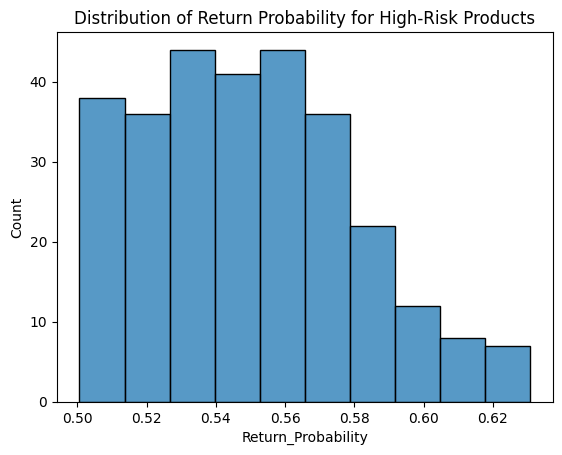

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(high_risk["Return_Probability"])
plt.title("Distribution of Return Probability for High-Risk Products")
plt.show()


# Import mysql connector

In [ ]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Saigoms261094",
    database="ecommerce"
)

cursor = conn.cursor()
print("Connected Successfully 🎉")



## ### Step 7: SQL Integration (Optional but Required for Task)
We save cleaned and scored data into MySQL and run basic SQL queries for verification and analysis.


### Step 8: SQL Validation Queries

In [ ]:

import sqlite3

conn = sqlite3.connect("ecommerce.db")   # or your file name
cursor = conn.cursor()

print("Database connected successfully!")


In [ ]:
import pandas as pd
import sqlite3


In [ ]:
df = pd.read_csv("clean_ecommerce_return_dataset (1).csv")
df.head()


## Create Table in SQLite & Run SQL Query

In [ ]:
import sqlite3

# Connect database
conn = sqlite3.connect("ecommerce.db")
cursor = conn.cursor()

# Save dataframe as SQL table
df.to_sql("orders", conn, if_exists="replace", index=False)

print("Table created successfully!")


In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
cursor.fetchall()


In [ ]:
cursor.execute("PRAGMA table_info(orders);")
cursor.fetchall()


In [ ]:
query = """
SELECT category,
       ROUND(AVG(return_status) * 100, 2) AS return_rate
FROM orders
GROUP BY category
ORDER BY return_rate DESC;
"""

cursor.execute(query)

result = cursor.fetchall()

for row in result:
    print(row)
